<center><h1>Time series analysis</h1></center>
<center><h2>Laboratorio II</h2></center>
<br>


In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## Datos: Demandas


In [3]:
data = pd.read_csv('datasets/demanda.csv', index_col = 'TIPO', parse_dates=True, dayfirst=True, thousands='.')
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4084110,3131427,3277777,10493315
2018-05-01,4276830,3101854,3286778,10665462
2018-06-01,5569775,3231036,3123287,11924098
2018-07-01,6167114,3326186,3112541,12605842
2018-08-01,5359054,3237765,3112882,11709701


In [4]:
y = data['Residencial'].copy()
y.index = y.index.to_period(freq='M')

ts = data['Residencial']

In [5]:
y =y.astype(int)

In [46]:
y.tail()

TIPO
2018-04    4084110
2018-05    4276830
2018-06    5569775
2018-07    6167114
2018-08    5359054
Freq: M, Name: Residencial, dtype: int32

In [7]:
ts.tail()

TIPO
2018-04-01    4084110
2018-05-01    4276830
2018-06-01    5569775
2018-07-01    6167114
2018-08-01    5359054
Name: Residencial, dtype: int64

In [8]:
data.describe()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01
mean,4.745018e+06,3.193531e+06,3.201239e+06,1.113979e+07
std,6.270953e+05,1.937162e+05,1.070309e+05,7.643435e+05
min,3.754330e+06,2.900824e+06,2.950818e+06,9.793759e+06
25%,4.222957e+06,3.038991e+06,3.122472e+06,1.046609e+07
50%,4.715576e+06,3.151394e+06,3.215652e+06,1.112625e+07
75%,5.201443e+06,3.312378e+06,3.266523e+06,1.180056e+07
max,6.167114e+06,3.670275e+06,3.460880e+06,1.260584e+07


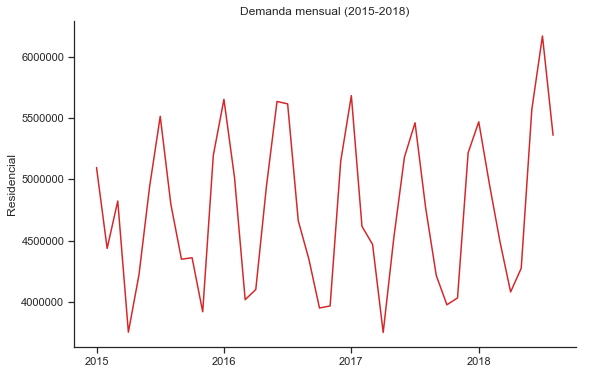

In [9]:
fig, ax= plt.subplots(figsize=(9,6))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Residencial')
ax.set_title('Demanda mensual (2015-2018)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

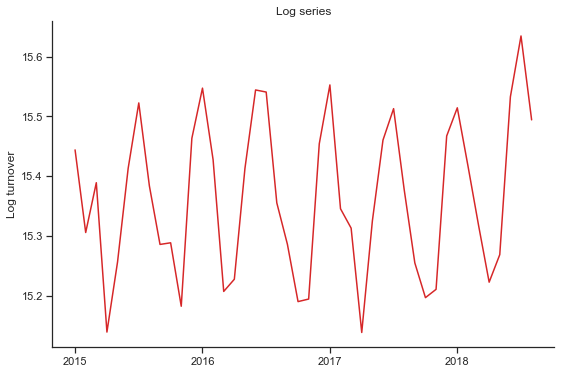

In [10]:
fig, ax= plt.subplots(figsize=(9,6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log turnover')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Time series decomposition

We use the X-13 ARIMA-SEATS method for time series decomposition. The X-13 method is a state-of-art time series decomposition approach developed and provided by the [US Census Bureau](https://www.census.gov/srd/www/x13as/) as external software. You need to make the X-13 software available to Python by downloading it from the link and extracting the compressed folder to your computer. The <TT>statsmodels</TT> library has a function that interfaces with this software, and the easiest way to get it to work is to copy the <TT>x13as</TT> executable to the same folder as your notebook.  

The X-13 is the current version of the X-12-ARIMA method described in the [textbook](https://www.otexts.org/fpp/6/4). The only limitation is that the X-13 software makes calendar effect adjustments based on the US calendar by default, though it is possible to reconfigure it to other calendars. Refer to the [ABS](http://abs.gov.au/websitedbs/d3310114.nsf/4a256353001af3ed4b2562bb00121564/c890aa8e65957397ca256ce10018c9d8) for the seasonal adjustment standards in Australia.  

In Linux you can use `get-x13as.sh` to get it.

In [11]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

You can use the <TT>dir</TT> method to check the available output. 

In [12]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [13]:
decomposition.seasadj.tail()

TIPO
2018-04-01    4.882490e+06
2018-05-01    4.459821e+06
2018-06-01    4.914140e+06
2018-07-01    5.105418e+06
2018-08-01    5.176299e+06
Name: seasadj, dtype: float64

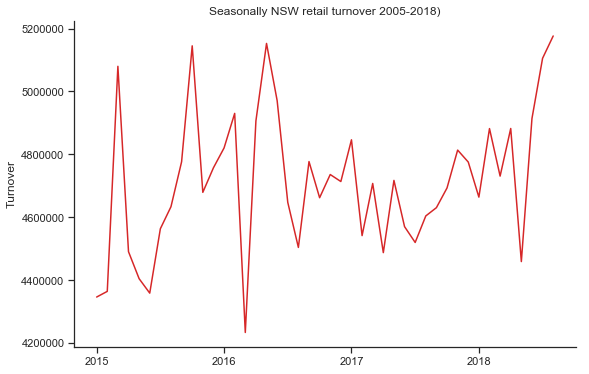

In [14]:
fig, ax= plt.subplots(figsize=(9,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally NSW retail turnover 2005-2018)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

The <TT>plotting</TT> module has a convenient function for plotting the components. 

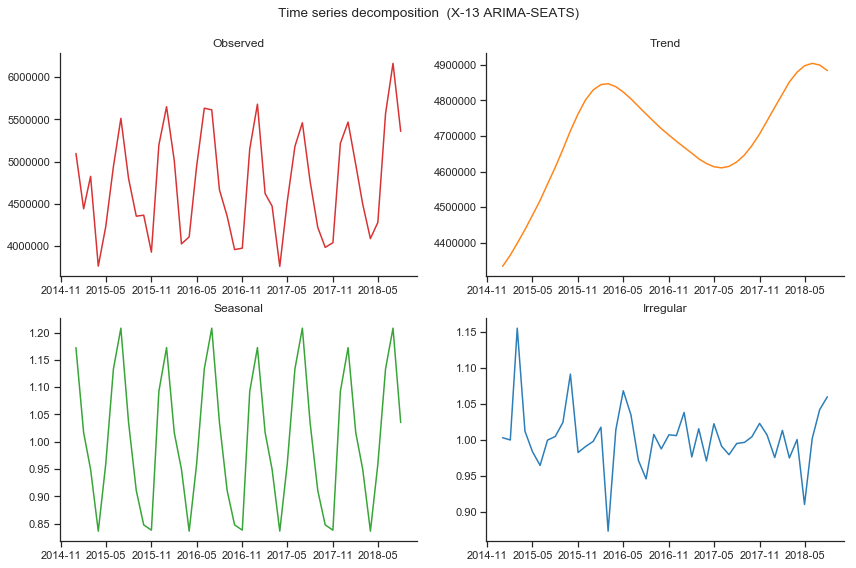

In [15]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

The X-13-ARIMA software generates a very detailed analysis of the time series, which is stored in the <TT>results</TT> attribute. You can view it with the <TT>print(decomposition.results)</TT> command, but due to the length I recommend saving it to a text file and opening it elsewhere. You can do this as follows.  

In [16]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

In case you are not able to work with the X13 decomposition software, a more basic decomposition is available as follows.

In [17]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

## Trend corrected exponential smoothing

Before we model and forecast the original series, the next cells demonstrate the application of the trend corrected exponential smoothing method, focusing on the seasonally adjusted series for coherence. 

In [18]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

In [19]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

 Smoothing parameter: alpha  0.001
 Smoothing parameter: betha  0.000
 In-sample fit:
 MSE               47798479956.872


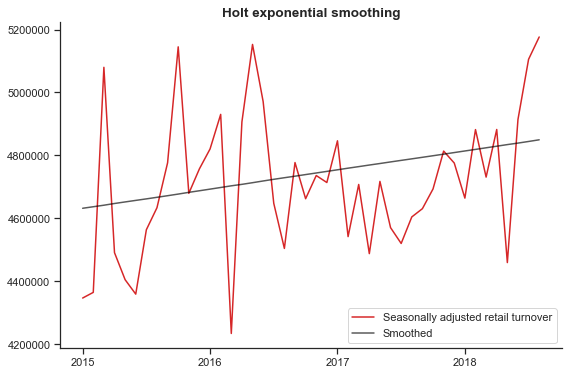

In [20]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots(figsize=(9,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed_sm['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

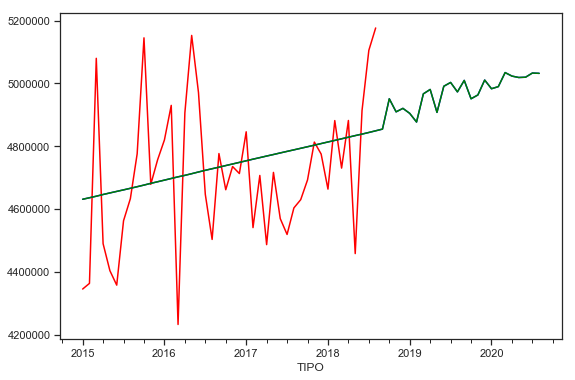

In [21]:
h=24
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

In [22]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [23]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()

In [24]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               90434390532.025
 RMSE               300723.113


In [25]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);


 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               72307305023.845
 RMSE               268900.177


In [26]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               72573196981.805
 RMSE               269394.129


In [27]:
ahw_log_sm=sm.tsa.ExponentialSmoothing(np.log(y), trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
hw_summary(ahw_log_sm);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               0.004
 RMSE               0.063


The smoothed series based on the multiplicative method tracks the original series very closely.

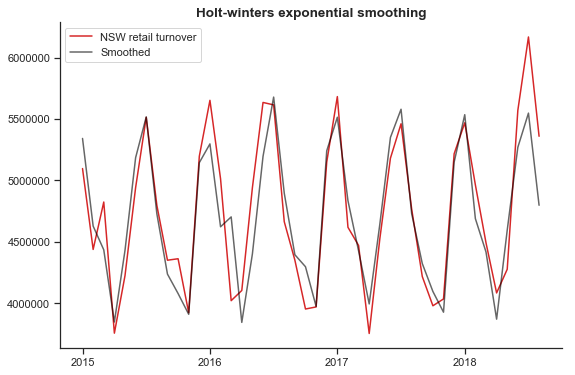

In [37]:
smoothed=pd.Series(mhw_damped.fittedvalues, index=y.index) #mhw_sm

fig, ax= plt.subplots(figsize=(9,6))

y['2015':].plot(color='#D62728', label='NSW retail turnover')
smoothed['2015':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

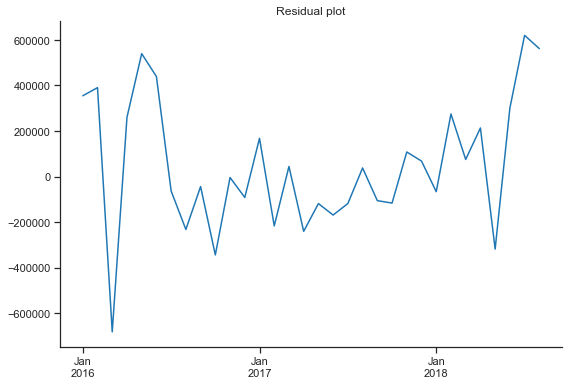

In [38]:
resid = (y-mhw_damped.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

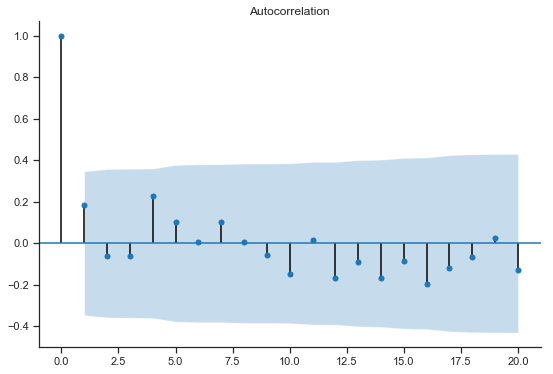

In [30]:
fig, ax = plt.subplots(figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
sns.despine()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


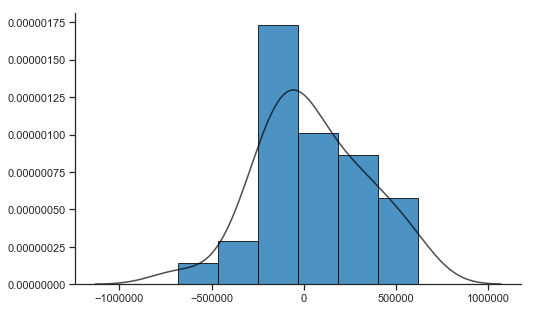

In [40]:
#from plotting import histogram

def histogram(resid):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(resid, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

histogram(resid)
plt.show()


## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [42]:
inicio = y.index[-round(len(y)/12*.2)*12]
inicio

Period('2017-09', 'M')

In [43]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y[inicio:].index
start = y.index.get_loc(inicio) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(ts.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    resid = (ts.iloc[:i]-model.fittedvalues)[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [44]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,337057.511,89037.376
Additive,301143.927,86151.895
Multiplicative,278224.405,80313.532
Log additive,288104.128,82451.311


## Forecast

Finally, we generate a two year forecast based on the selected model. 

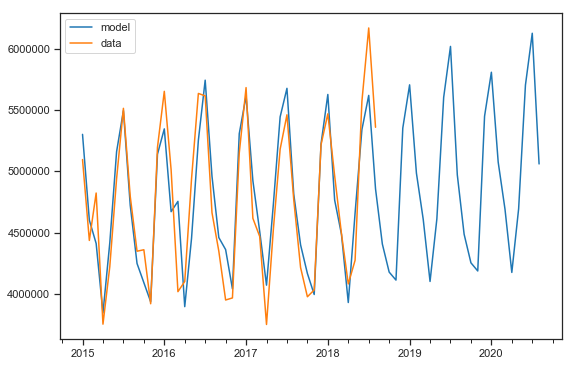

In [50]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = y
#pd.Series(model.fittedvalues + model.fcastvalues), 
#                         index=pd.period_range(y.index[0],y.index[-1]+h,freq=y.index.freq))

plot['2015':].plot(figsize=(9,6));